In [1]:
from hossam import *
from pandas import DataFrame, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import log_loss, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve

from scipy.spatial import ConvexHull

from 성능평가함수 import *

import shap

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline as imbPipeline

In [2]:
origin=load_data('pima_indians_diabetes_preprocessed')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

캐글에서 제공하는 pima_indians_diabetes의 전처리 완료 버전(결측치 정제+로그변환) (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

===== 데이터 크기 확인 =====
데이터셋 크기 : (768, 9)
행 개수 : 768개
열 개수 : 9개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 54.1 KB
None


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.946,5.004,72,3.584,4.836,3.544,0.487,3.932,1
1,0.693,4.454,66,3.401,4.836,3.318,0.301,3.466,0
2,2.197,5.215,64,3.401,4.836,3.190,0.514,3.497,1
3,0.693,4.500,66,3.178,4.554,3.371,0.154,3.091,0
4,0.000,4.927,40,3.584,5.130,3.786,1.190,3.526,1


In [3]:
df=origin.copy()

df['Outcome']=df['Outcome'].astype('int')

yname='Outcome'
x=df.drop(columns=[yname])
y=df[yname]

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=52)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

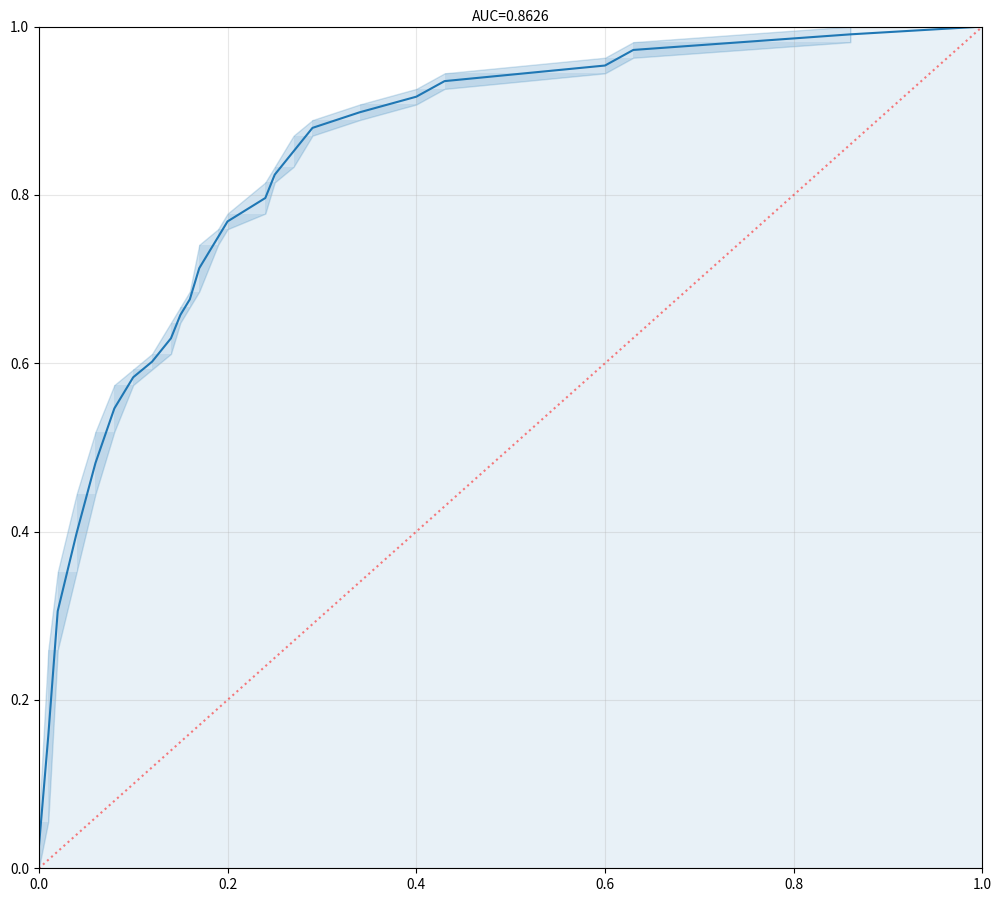

CPU times: total: 1.92 s
Wall time: 29.3 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
RandomForestClassifier,0.773,0.638,0.815,0.250,0.750,0.715,0.863


In [4]:
%%time

rf_cls_pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=52, n_jobs=-1))
])

rf_cls_param_grid={
    'model__n_estimators':[300, 500],
    'model__max_depth':[None, 10],
    'model__min_samples_leaf':[5, 10],
    'model__max_features':['sqrt', 1.0],
    'model__criterion':['gini', 'entropy'],
    'model__class_weight':[None, 'balanced']
}

rf_cls_gs=GridSearchCV(estimator=rf_cls_pipe, param_grid=rf_cls_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

rf_cls_gs.fit(x_train, y_train)

rf_cls_estimator=rf_cls_gs.best_estimator_

rf_cls_score_df=hs_cls_bin_scores(rf_cls_estimator, x_test, y_test)
rf_cls_score_df

In [5]:
origin['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

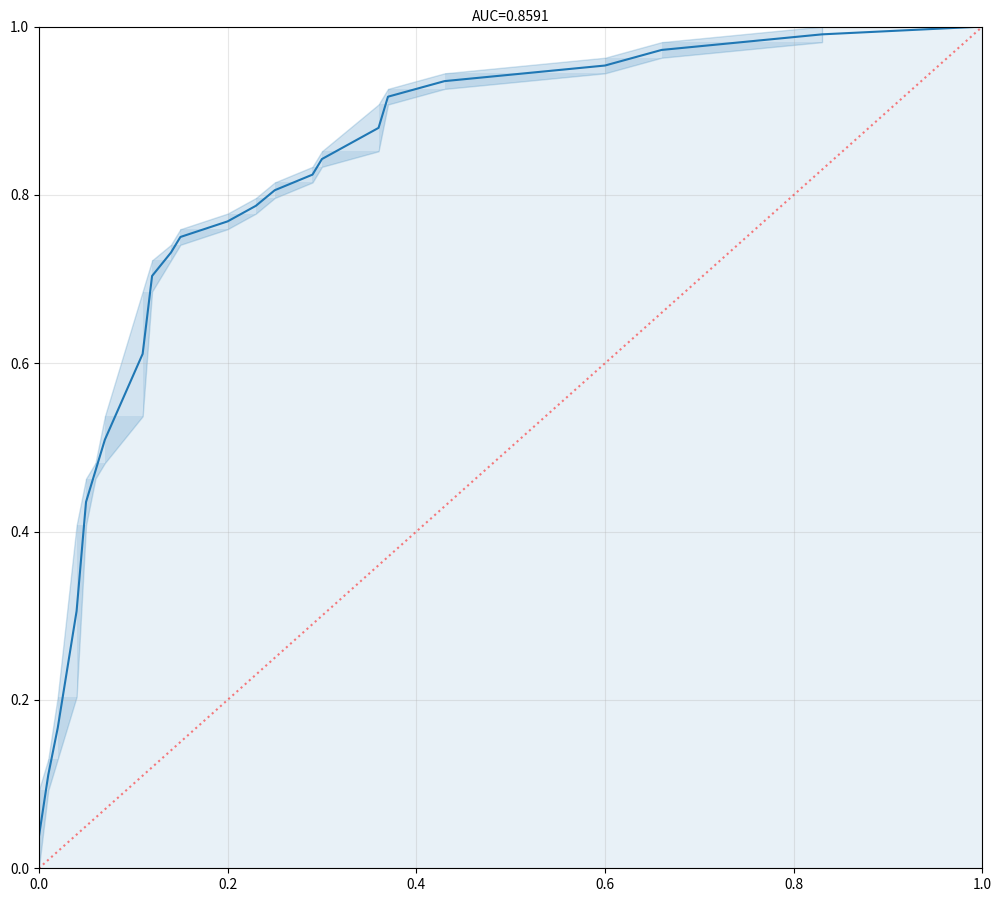

,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
기본,0.773,0.638,0.815,0.250,0.750,0.715,0.863
언더샘플링,0.760,0.620,0.815,0.270,0.730,0.704,0.859


In [7]:
rus_pipe=imbPipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=52)),
    ('model', RandomForestClassifier(random_state=52, n_jobs=-1))
])

rus_param_grid={
    'model__n_estimators':[300, 500],
    'model__max_depth':[None, 10],
    'model__min_samples_leaf':[5, 10],
    'model__max_features':['sqrt', 1.0],
    'model__criterion':['gini', 'entropy'],
    'model__class_weight':[None, 'balanced']
}

rus_gs=GridSearchCV(estimator=rus_pipe, param_grid=rus_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

rus_gs.fit(x_train, y_train)
rf_cls_estimator=rus_gs.best_estimator_
rus_score_df=hs_cls_bin_scores(rf_cls_estimator, x_test, y_test)
rdf=concat([rf_cls_score_df, rus_score_df], axis=0)
rdf.index=['기본', '언더샘플링']
rdf

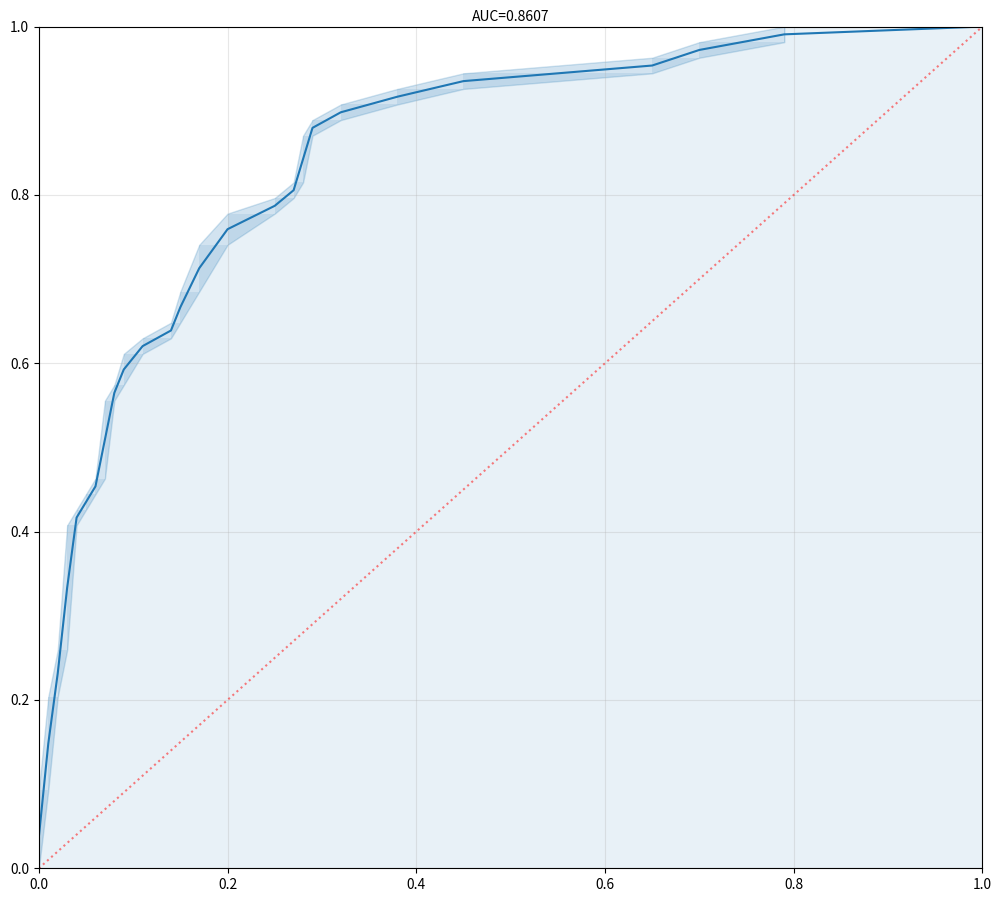

,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
기본,0.773,0.638,0.815,0.250,0.750,0.715,0.863
언더샘플링,0.760,0.620,0.815,0.270,0.730,0.704,0.859
오버샘플링,0.760,0.620,0.815,0.270,0.730,0.704,0.861


In [8]:
ros_pipe=imbPipeline([
    ('scaler', StandardScaler()),
    ('ros', RandomOverSampler(random_state=52)),
    ('model', RandomForestClassifier(random_state=52, n_jobs=-1))
])

ros_param_grid={
    'model__n_estimators':[300, 500],
    'model__max_depth':[None, 10],
    'model__min_samples_leaf':[5, 10],
    'model__max_features':['sqrt', 1.0],
    'model__criterion':['gini', 'entropy'],
    'model__class_weight':[None, 'balanced']
}

ros_gs=GridSearchCV(estimator=ros_pipe, param_grid=ros_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

ros_gs.fit(x_train, y_train)
rf_cls_estimator=ros_gs.best_estimator_
ros_score_df=hs_cls_bin_scores(rf_cls_estimator, x_test, y_test)
rdf=concat([rf_cls_score_df, rus_score_df, ros_score_df], axis=0)
rdf.index=['기본', '언더샘플링', '오버샘플링']
rdf

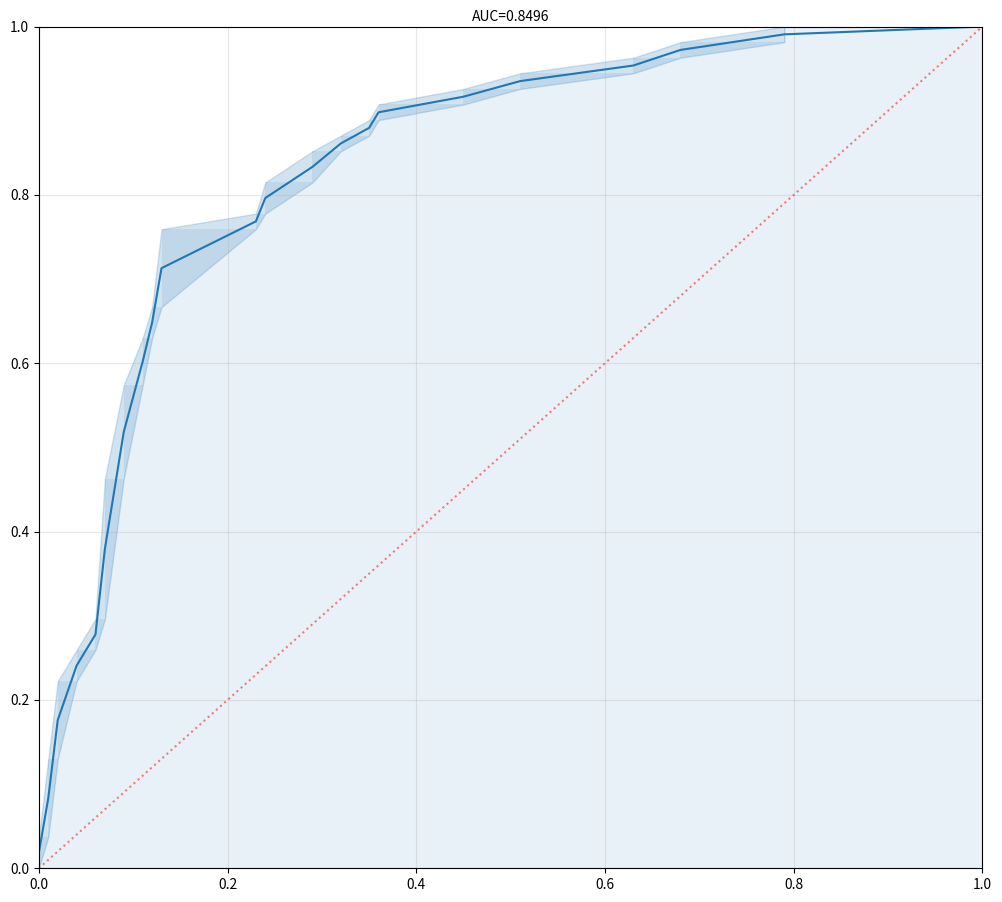

,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
기본,0.773,0.638,0.815,0.250,0.750,0.715,0.863
언더샘플링,0.760,0.620,0.815,0.270,0.730,0.704,0.859
오버샘플링,0.760,0.620,0.815,0.270,0.730,0.704,0.861
SMOTE,0.766,0.629,0.815,0.260,0.740,0.710,0.850


In [9]:
sm_pipe=imbPipeline([
    ('scaler', StandardScaler()),
    ('sm', SMOTE(random_state=52, k_neighbors=5)),
    ('model', RandomForestClassifier(random_state=52, n_jobs=-1))
])

sm_param_grid={
    'model__n_estimators':[300, 500],
    'model__max_depth':[None, 10],
    'model__min_samples_leaf':[5, 10],
    'model__max_features':['sqrt', 1.0],
    'model__criterion':['gini', 'entropy'],
    'model__class_weight':[None, 'balanced']
}

sm_gs=GridSearchCV(estimator=sm_pipe, param_grid=sm_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

sm_gs.fit(x_train, y_train)
rf_cls_estimator=sm_gs.best_estimator_
sm_score_df=hs_cls_bin_scores(rf_cls_estimator, x_test, y_test)
rdf=concat([rf_cls_score_df, rus_score_df, ros_score_df, sm_score_df], axis=0)
rdf.index=['기본', '언더샘플링', '오버샘플링', 'SMOTE']
rdf